In [28]:
import equinox as eqx
import pandas as pd
from sklearn.datasets import fetch_openml
from sklearn.model_selection import train_test_split
import jax
from jaxtyping import Array, Float, Int, PyTree  # https://github.com/google/jaxtyping
import matplotlib.pyplot as plt
import numpy as np
import jax.numpy as jnp
import optax
import optimistix as optx
import jaxopt
import time

In [29]:
mnist = fetch_openml('mnist_784', version=1, as_frame=True)

X = mnist.data.to_numpy().astype(np.float64)
y = mnist.target.to_numpy().astype(np.int32)
#y = pd.get_dummies(mnist.target).to_numpy()

Text(0.5, 1.0, '0')

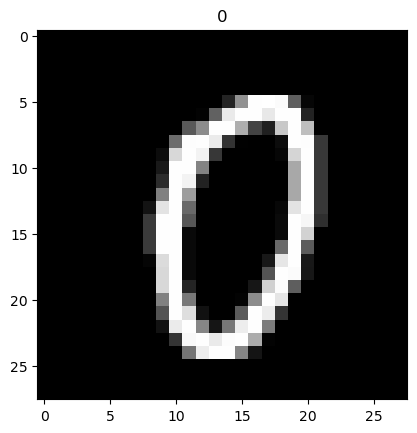

In [30]:
test_X = X[1000].reshape(28, 28)
test_y = y[1000]
plt.imshow(test_X, cmap='grey')
plt.title(f"{test_y}")

In [31]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [32]:
class MNISTNet(eqx.Module): # ~10^4 parameters
    layers: list
    
    def __init__(self, key):
        key1, key2, key3, key4 = jax.random.split(key, 4)
        self.layers = [
            eqx.nn.Linear(784, 20, key=key1),
            jax.nn.relu,
            eqx.nn.Linear(20, 10, key=key3),
            jax.nn.softmax,
        ]
    def __call__(self, x: Float[Array, " 1 784"]) -> Float[Array, " 10"]:
        for layer in self.layers:
            x = layer(x)
        return x

In [74]:
def cross_entropy(y, pred_y):
    pred_y = jnp.take_along_axis(pred_y, jnp.expand_dims(y, 1), axis=1)
    return -jnp.mean(pred_y)

def l2reg(model):
    total = 0
    params = list(filter(lambda x: x != None, eqx.filter(model, eqx.is_array).layers)) # filter model to contain only the linear layers
    for layer in params:
        total += (jnp.sum(layer.weight ** 2) + jnp.sum(layer.bias ** 2))
    return total

def l2reg2(params):
    params_list = list(filter(lambda x: x != None, params.layers))
    total = 0
    for layer in params_list:
        total += (jnp.sum(layer.weight ** 2) + jnp.sum(layer.bias ** 2))
    return total

def loss(model, lam, X: Float[Array, " batch 1 784"], y: Int[Array, " batch"]):
    pred_y = jax.vmap(model)(X)
    return cross_entropy(y, pred_y) + lam * l2reg(model)

def loss2(params, static, lam, X: Float[Array, " batch 1 784"], y: Int[Array, " batch"]):
    model = eqx.combine(params, static)
    return loss(model, lam, X, y)

def val_loss2(params, static, X, y):
    model = eqx.combine(params, static)
    return val_loss(model, X, y)

def val_loss(model, X, y):
    pred_y = jax.vmap(model)(X)
    return cross_entropy(y, pred_y)

def loss_optx(params, args):
    static, lam, X, y = args
    model = eqx.combine(params, static)
    return loss(model, lam, X, y)

In [75]:
def dataloader(arrays, batch_size):
    dataset_size = arrays[0].shape[0]
    assert all(array.shape[0] == dataset_size for array in arrays)
    indices = np.arange(dataset_size)
    while True:
        perm = np.random.permutation(indices)
        start = 0
        end = batch_size
        while end <= dataset_size:
            batch_perm = perm[start:end]
            yield tuple(array[batch_perm] for array in arrays)
            start = end
            end = start + batch_size

def train_model(lam,
    X_train=X_train,
    y_train=y_train,
    learning_rate=1e-4,
    batch_size=100,
    seed=42,
    steps=30):           
    
    _, model_key = jax.random.split(jax.random.PRNGKey(seed), 2)
    model = MNISTNet(model_key)
    
    optim = optax.adam(learning_rate)
    
    @eqx.filter_jit
    def make_step(model, x, y, opt_state):
        loss_val, grads = eqx.filter_value_and_grad(loss)(model, lam, x, y)
        updates, opt_state = optim.update(grads, opt_state)
        model = eqx.apply_updates(model, updates)
        return loss_val, model, opt_state
    
    iter_data = dataloader((X_train, y_train), batch_size)
    
    opt_state = optim.init(eqx.filter(model, eqx.is_array))
    for step, (x, y) in zip(range(steps), iter_data):
        loss_val, model, opt_state = make_step(model, x, y, opt_state)
    
    return model

"""
Using optimistix minimiser to train the model
"""
def train_model_optx_and_evaluate_acc(lam, args,
    X_train=X_train,
    y_train=y_train,
    X_test=X_test,
    y_test=y_test,
    learning_rate=1e-4,
    batch_size=100,
    seed=42,
    steps=2):           
    
    _, model_key = jax.random.split(jax.random.PRNGKey(seed), 2)
    model = MNISTNet(model_key)
    params, static = eqx.partition(model, eqx.is_array)
    solver = optx.OptaxMinimiser(optax.adam(learning_rate), rtol=1e-3, atol=1e-3)

    sol = optx.minimise(loss_optx, solver, y0=params, args=(static, lam, X_train[:batch_size], y_train[:batch_size]), max_steps=steps)
    params = sol.value
    acc = model_acc2(params, static, X_test, y_test)
    return lam * l2reg2(params)

def test_accuracy(model, X, y):
    y_pred = jax.vmap(model)(X)
    y_pred = jnp.argmax(y_pred, axis=1)
    return jnp.mean(y_pred == y)

def test_accuracy2(params, static, X, y):
    model = eqx.combine(params, static)
    return test_accuracy(model, X, y)

def train_and_evaluate_test_accuracy(lam, args):
    params, static = train_model(lam, X_train=X_train,
                        y_train=y_train,
                        learning_rate=1e-4,
                        batch_size=100,
                        seed=42,
                        steps=100,
                   )
    acc = test_accuracy2(params, static)
    print(f"acc = {acc}")
    return

def train_using_optx_solver_and_evaluate_test_accuracy(lam, args):
    params, static = train_model_optx(lam, X_train=X_train,
                        y_train=y_train,
                        learning_rate=1e-4,
                        batch_size=100,
                        seed=42,
                        steps=1000,
                   )
    acc = test_accuracy2(params, static)
    print(f"acc = {acc}, type = {type(acc)}")
    return acc

def train_and_evaluate_test_accuracy_jaxopt(params_init, static_init, lam, X_train, y_train, seed=42):
    params_end = train_model_jaxopt(params_init, static_init, lam, X_train, y_train)
    model = eqx.combine(params_end, static_init)
    acc = test_accuracy(model)
    print(acc)
    return test_accuracy(model)

In [95]:
"""
Use optax minimiser to train the model
"""
#@jaxopt.implicit_diff.custom_root(jax.grad(loss2))
def train_model_optax_and_evaluate_acc(params_init, static_init, lam, X_train, y_train):
    
    learning_rate=1e-4
    batch_size=100
    seed=42
    steps=100
    
    params = params_init
    static = static_init
    optim = optax.adam(learning_rate)
    
    @eqx.filter_jit
    def make_step(params, x, y, opt_state):
        loss_val, grads = jax.value_and_grad(loss2)(params, static, lam, x, y)
        updates, opt_state = optim.update(grads, opt_state)
        params = eqx.apply_updates(params, updates)
        return loss_val, params, opt_state
    
    iter_data = dataloader((X_train, y_train), batch_size)
    
    opt_state = optim.init(params_init)
    for step, (x, y) in zip(range(steps), iter_data):
        loss_val, params, opt_state = make_step(params, x, y, opt_state)
    
    val = val_loss2(params, static, X_test, y_test)
    return val

"""
Using optimistix minimiser to train the model
"""
def train_model_optx_and_compute_acc(lam, args,
    X_train=X_train,
    y_train=y_train,
    X_test=X_test,
    y_test=y_test,                                 
    learning_rate=1e-4,
    batch_size=10,
    seed=42,
    steps=1000):
    
    # initialize model
    _, model_key = jax.random.split(jax.random.PRNGKey(seed), 2)
    model = MNISTNet(model_key)
    
    params, static = eqx.partition(model, eqx.is_array)
    
    # initialize optax adam solver (with optimistix)
    solver = optx.OptaxMinimiser(optax.adam(learning_rate), rtol=1e-3, atol=1e-3)
    
    # minimise loss to find the optimal params, compute model accuracy
    # TODO - iterative solver
    sol = optx.minimise(loss_optx, solver, y0=params, adjoint=optx.ImplicitAdjoint(), args=(static, lam, X_train[:batch_size], y_train[:batch_size]), max_steps=steps)
    params = sol.value
    val = val_loss2(params, static, X_test, y_test)
    return val

In [88]:
_, model_key = jax.random.split(jax.random.PRNGKey(42), 2)
model = MNISTNet(model_key)
params_init, static_init = eqx.partition(model, eqx.is_array)
acc1 = train_model_optax_and_evaluate_acc(params_init, static_init, 0.1, X_train, y_train)
jax.value_and_grad(train_model_optax_and_evaluate_acc, argnums=2)(params_init, static_init, 0.1, X_train, y_train)

(Array(-0.29180443, dtype=float32),
 Array(-14.953585, dtype=float32, weak_type=True))

In [94]:
def find_optimal_reg_implicit_optx():
    # initialize adam optimisizer
    optim = optx.OptaxMinimiser(optax.adam(1e-4), rtol=1e-4, atol=1e-4, verbose=frozenset({"step", "y", "loss"}))
    
    # implicit diff on train_model_optx_and_compute_acc
    sol = optx.minimise(train_model_optx_and_compute_acc, optim, adjoint=optx.ImplicitAdjoint(), y0=1.0, args=0, max_steps=10)

find_optimal_reg_implicit_optx()

Step: 0, Loss: -0.22727148234844208, y: 1.0
Step: 1, Loss: -0.19062981009483337, y: 1.000100016593933
Step: 2, Loss: -0.2192959487438202, y: 1.0001883506774902
Step: 3, Loss: -0.24245917797088623, y: 1.000274896621704
Step: 4, Loss: -0.2098533809185028, y: 1.0003430843353271
Step: 5, Loss: -0.22246181964874268, y: 1.0004117488861084
Step: 6, Loss: -0.228701651096344, y: 1.000480055809021
Step: 7, Loss: -0.2302989512681961, y: 1.0005396604537964
Step: 8, Loss: -0.2313893884420395, y: 1.0005924701690674


KeyboardInterrupt: 

In [ ]:
print(jax.grad(train_model_optx_test, argnums=0)(0.1))

In [8]:
_, model_key = jax.random.split(jax.random.PRNGKey(42), 2)
model = MNISTNet(model_key)
params_init, static_init = eqx.partition(model, eqx.is_array)
#jax.grad(loss2, argnums=2)(params_init, static_init, 1e-3, X_train, y_train)
jax.grad(train_and_evaluate_test_accuracy_jaxopt, argnums=2)(params_init, static_init, 1e-3, X_train, y_train)

training the model
done training
0.3347143


Array(0., dtype=float32, weak_type=True)

In [44]:
lams = jnp.arange(-5, -2, 0.1)
ys = []
for lam in lams:
    acc = train_and_evaluate_test_accuracy(jnp.exp(lam), None)
    ys.append(acc)
plt.plot(lams, ys)
plt.title("accuracy on MNIST")
plt.xlabel("log reg weight")
plt.ylabel("model accuracy")

KeyboardInterrupt: 

In [9]:
@eqx.filter_jit
def find_optimal_reg_implicit_optx(learning_rate=1e-4,
                                   reg_init = 0):
    optim = optx.OptaxMinimiser(optax.adam(learning_rate), rtol=1e-4, atol=1e-4, verbose=frozenset({"step", "loss"}))
    sol = optx.minimise(train_and_evaluate_test_accuracy, optim, adjoint=optx.ImplicitAdjoint(), y0=reg_init, args=0, max_steps=1)
    return sol

@eqx.filter_jit
def find_optimal_reg_implicit_optx2(learning_rate=1e-4,
                                   reg_init=0.1):
    optim = optx.OptaxMinimiser(optax.adam(learning_rate), rtol=1e-4, atol=1e-4, verbose=frozenset({"step", "y", "loss"}))
    sol = optx.minimise(train_using_optx_solver_and_evaluate_test_accuracy, optim, adjoint=optx.ImplicitAdjoint(), y0=reg_init, args=0, max_steps=10)
    return sol

def find_optimal_reg_implicit_jaxopt(): # todo
    
    pass

In [11]:
train_using_optx_solver_and_evaluate_test_accuracy(0.1, None)

acc = 0.692642867565155, type = <class 'jaxlib.xla_extension.ArrayImpl'>


Array(0.69264287, dtype=float32)

In [12]:
# t1 = time.time()
# find_optimal_reg_implicit_optx()
# t2 = time.time() - t1
# print(f"solving with optax solver: {t2}")

t1 = time.time()
find_optimal_reg_implicit_optx2()
t2 = time.time() - t1
print(f"solving with optimistix solver: {t2}")

acc = Traced<ShapedArray(float32[])>with<DynamicJaxprTrace(level=3/0)>, type = <class 'jax._src.interpreters.partial_eval.DynamicJaxprTracer'>
Step: 0, Loss: 0.692642867565155, y: 0.10000000149011612
Step: 1, Loss: 0.692642867565155, y: 0.10000000149011612
solving with optimistix solver: 2.745856761932373


In [ ]:
model = train_model(1e-4)
print(test_accuracy(model))

In [30]:
import jax
import jax.numpy as jnp
import equinox as eqx
import optimistix as optx

jax.config.update("jax_enable_x64", True)

# Sample data
X = jax.random.normal(jax.random.PRNGKey(0), (2000, 8))

# Define the function
@jax.vmap
def function(x):
    return x[0] + x[1] ** 2 + jnp.cos(x[2]) + jnp.sin(x[3]) + x[4] * x[5] + (x[6] * x[7]) ** 3

# Compute the output for y
y = function(X).reshape(-1, 1)  # This is a column vector with shape (2000, 1)

# Define the MLP model
model = eqx.nn.MLP(in_size=8, out_size=1, width_size=4, depth=2, activation=jax.nn.silu, key=jax.random.PRNGKey(0))

# Partition the parameters of the model (params) and static (non-trainable) parts
params, static = eqx.partition(model, eqx.is_array)

# Loss function
def loss_fn(params, static):
    model = eqx.combine(params, static)
    model_output = jax.vmap(model)(X)
    return jnp.sum((model_output - y) ** 2)

# Set up the solver
solver = optx.BFGS(rtol=1e-5, atol=1e-5)

# Minimize the loss function
sol = optx.minimise(loss_fn, solver, params, args=static, max_steps=2**14)
print(sol)

Solution(
  value=MLP(
    layers=(
      Linear(
        weight=f64[4,8],
        bias=f64[4],
        in_features=8,
        out_features=4,
        use_bias=True
      ),
      Linear(
        weight=f64[4,4],
        bias=f64[4],
        in_features=4,
        out_features=4,
        use_bias=True
      ),
      Linear(
        weight=f64[1,4],
        bias=f64[1],
        in_features=4,
        out_features=1,
        use_bias=True
      )
    ),
    activation=None,
    final_activation=None,
    use_bias=True,
    use_final_bias=True,
    in_size=8,
    out_size=1,
    width_size=4,
    depth=2
  ),
  result=EnumerationItem(
    _value=i32[],
    _enumeration=<class 'optimistix._solution.RESULTS'>
  ),
  aux=None,
  stats={'max_steps': 16384, 'num_steps': weak_i64[]},
  state=_BFGSState(
    first_step=bool[],
    y_eval=MLP(
      layers=(
        Linear(
          weight=f64[4,8],
          bias=f64[4],
          in_features=8,
          out_features=4,
          use_bias=True